In [144]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load the dataset
filepath = '/Users/latifahjones/Desktop/predicting-diabetic-outcomes/Resources/originaldataset.csv'
data = pd.read_csv(filepath)

In [3]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [4]:
# Filling missing values for BMI with the median
data['BMI'] = data['BMI'].fillna(data['BMI'].median())

# Scaling numerical features
scaler = StandardScaler()
data[['BMI', 'WeightInKilograms']] = scaler.fit_transform(data[['BMI', 'WeightInKilograms']])

In [5]:
print(data.select_dtypes(include='object').columns)


Index(['State', 'Sex', 'GeneralHealth', 'AgeCategory', 'HadDiabetes',
       'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory',
       'TetanusLast10Tdap'],
      dtype='object')


In [6]:
# List of columns to encode
categorical_cols = ['State', 'Sex', 'GeneralHealth', 'AgeCategory', 
                    'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 
                    'TetanusLast10Tdap']

# Perform one-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the first few rows of the encoded dataset
print(data_encoded.head())


   PatientID  HeightInMeters  WeightInKilograms       BMI  HadHeartAttack  \
0          1            1.63           0.053935  0.522115               0   
1          2            1.60          -0.561675 -0.107475               0   
2          3            1.78          -0.583210 -0.943865               0   
3          4            1.78           0.542209  0.220341               0   
4          5            1.68          -0.264404 -0.142707               0   

   HadAngina  HadStroke  HadAsthma  HadSkinCancer  HadCOPD  ...  \
0          1          0          1              1        0  ...   
1          0          0          0              0        0  ...   
2          0          0          0              0        0  ...   
3          0          0          0              0        0  ...   
4          0          0          0              0        0  ...   

   ECigaretteUsage_Not at all (right now)  ECigaretteUsage_Use them every day  \
0                                   False            

In [7]:
# Check for object columns
print(data_encoded.dtypes[data_encoded.dtypes == 'object'])

# Ensure the target variable is numerical
data_encoded['HadDiabetes'] = data_encoded['HadDiabetes'].map({'Yes': 1, 'No': 0})
print(data_encoded['HadDiabetes'].unique())


HadDiabetes    object
dtype: object
[ 1.  0. nan]


In [8]:
# Check for missing values in 'HadDiabetes'
print(data_encoded['HadDiabetes'].isnull().sum())  # Should show how many NaNs exist

7112


In [9]:
data_encoded = data_encoded.dropna(subset=['HadDiabetes'])

# Ensure no NaN values remain and check unique values
print(data_encoded['HadDiabetes'].isnull().sum())  # Should output 0
print(data_encoded['HadDiabetes'].unique())       # Should output [1.0, 0.0]

0
[1. 0.]


___

## Exploratory Data Analysis (EDA)
1. Understanding the range and distribution of key numerical features.
2. Visualizing the distribution of a key categorical feature, such as GeneralHealth.
3. Identifying the relationships and multicollinearity.
4. This ensures the target variable (HadDiabetes) is balanced.

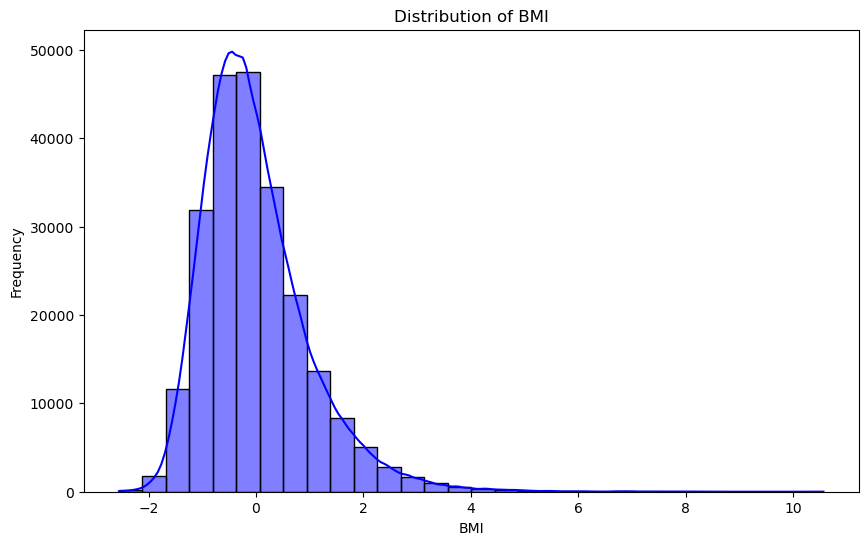

In [20]:
# 1. Distribution of Numerical Variables (e.g., BMI)

plt.figure(figsize=(10, 6))
sns.histplot(data_encoded['BMI'], kde=True, bins=30, color='blue')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

### Numerical Variable Insights
- `BMI` is normally distributed, with most values falling between [range].
- Weight has outliers at the higher end, which may affect model predictions.

In [43]:
# One-hot encoded columns for GeneralHealth
general_health_columns = [col for col in data_encoded.columns if 'GeneralHealth_' in col]

# Combine them back into a single column
data_encoded['GeneralHealth'] = data_encoded[general_health_columns].idxmax(axis=1).str.replace('GeneralHealth_', '')

print(data_encoded['GeneralHealth'].unique())

['Fair' 'Very good' 'Good' 'Poor']


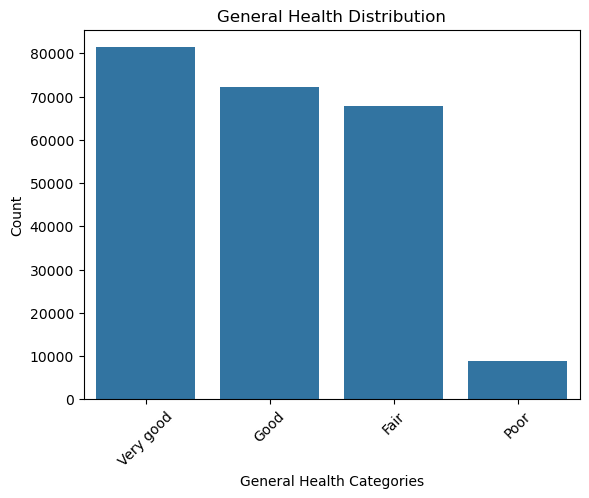

In [45]:
# 2. Count Plot for Categorical Variables

sns.countplot(x='GeneralHealth', data=data_encoded, order=data_encoded['GeneralHealth'].value_counts().index)
plt.title('General Health Distribution')
plt.xlabel('General Health Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Categorical Variable Insights
- `GeneralHealth` is dominated by the 'Very good' category, with fewer respondents in 'Poor' and 'Fair' categories.
- This skew could influence model performance and may require additional balancing.

In [95]:
# Remove the 'PatientID' column
data_encoded = data_encoded.drop(columns=['PatientID'], errors='ignore')

# Verify the column is removed
print(data_encoded.columns)

Index(['HeightInMeters', 'WeightInKilograms', 'BMI', 'HadHeartAttack',
       'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder',
       ...
       'RaceEthnicityCategory_Hispanic',
       'RaceEthnicityCategory_Multiracial, Non-Hispanic',
       'RaceEthnicityCategory_Other race only, Non-Hispanic',
       'RaceEthnicityCategory_White only, Non-Hispanic',
       'TetanusLast10Tdap_Yes, received Tdap',
       'TetanusLast10Tdap_Yes, received tetanus shot but not sure what type',
       'TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap',
       'GeneralHealth_Good', 'GeneralHealth_Poor', 'GeneralHealth_Very good'],
      dtype='object', length=112)


In [103]:
# Select top 10 correlated features with 'HadDiabetes'
top_features = sorted_corr[2:11].index  # Skip 'HadDiabetes' itself
limited_corr_matrix = corr_matrix.loc[top_features, top_features]

# Display the top correlations with 'HadDiabetes'
print("Top correlations with 'HadDiabetes':")
print(sorted_corr)

Top correlations with 'HadDiabetes':
HadDiabetes                  1.000000
DifficultyWalking            0.218627
BMI                          0.205723
PneumoVaxEver                0.187953
WeightInKilograms            0.172576
HadKidneyDisease             0.169284
HadArthritis                 0.161534
HadAngina                    0.158846
HadHeartAttack               0.149590
ChestScan                    0.147959
HadStroke                    0.113305
DifficultyErrands            0.105715
HadCOPD                      0.105470
DifficultyDressingBathing    0.101538
FluVaxLast12                 0.098270
BlindOrVisionDifficulty      0.091841
DeafOrHardOfHearing          0.084489
DifficultyConcentrating      0.064807
HadAsthma                    0.049390
HadDepressiveDisorder        0.047394
HadSkinCancer                0.028253
CovidPos                    -0.008759
HeightInMeters              -0.015238
HIVTesting                  -0.018244
HighRiskLastYear            -0.039268
AlcoholDrinke

In [111]:
# Filter for features with moderate correlations (threshold: 0.15)
top_features = sorted_corr[abs(sorted_corr) >= 0.15].index

# Create a subset of the correlation matrix for the top features
top_corr_matrix = corr_matrix.loc[top_features, top_features]

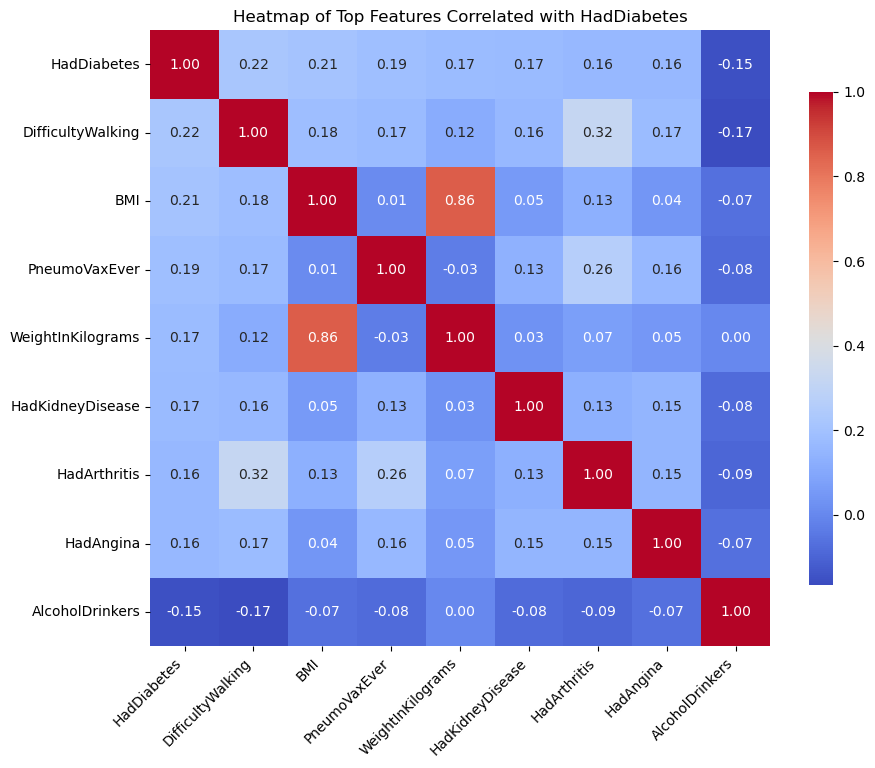

In [123]:
# Heatmap for the top features
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Heatmap of Top Features Correlated with HadDiabetes')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Heatmap of Top Correlated Features
1. The heatmap shows the pairwise correlations among the top features correlated with `HadDiabetes`.
2. Strong correlations, such as between `BMI` and `WeightInKilograms`, suggest potential multicollinearity that could affect model performance.
3. Features like `DifficultyWalking` and `PneumoVaxEver` show moderate correlations with `HadDiabetes`, making them strong candidates for predictive modeling.
4. This analysis will guide feature selection for the models to ensure both interpretability and performance.

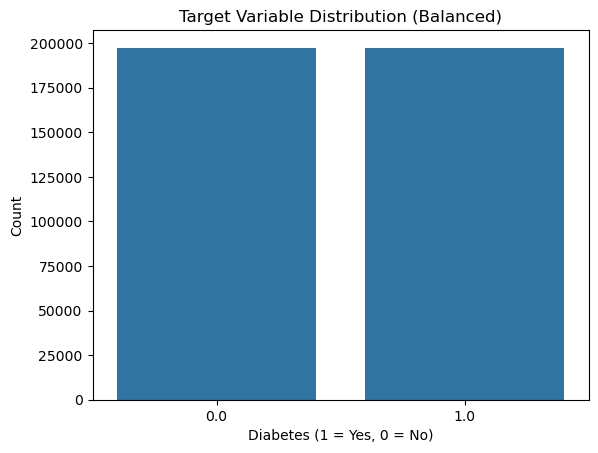

In [128]:
# Separate majority and minority classes
majority_class = data_encoded[data_encoded['HadDiabetes'] == 0]
minority_class = data_encoded[data_encoded['HadDiabetes'] == 1]

# Oversample the minority class
minority_oversampled = resample(minority_class, 
                                replace=True, 
                                n_samples=len(majority_class), 
                                random_state=42)

# Combine oversampled minority class with majority class
data_balanced = pd.concat([majority_class, minority_oversampled])

# Verify the new target variable distribution
sns.countplot(x='HadDiabetes', data=data_balanced)
plt.title('Target Variable Distribution (Balanced)')
plt.xlabel('Diabetes (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [130]:
# Features and target variable
X = data_encoded.drop('HadDiabetes', axis=1)  # Features
y = data_encoded['HadDiabetes']  # Target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.86


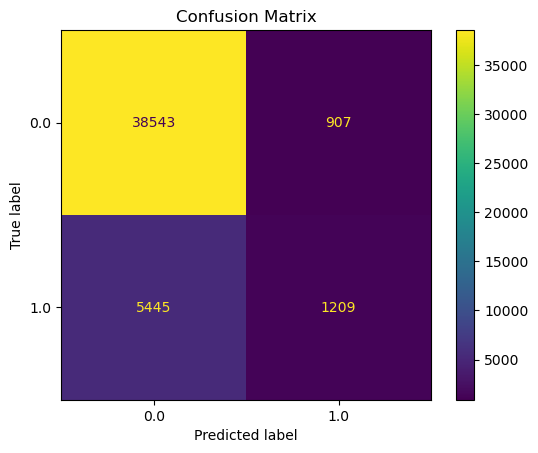

In [132]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Model Performance: Logistic Regression
1. **Accuracy:** The Logistic Regression model achieved an accuracy of 86%, which is a good baseline for predicting diabetes.
2. **Confusion Matrix:**
   - **True Negatives (non-diabetes correctly predicted):** 38,543
   - **True Positives (diabetes correctly predicted):** 1,209
   - **False Positives (non-diabetes incorrectly predicted as diabetes):** 907
   - **False Negatives (diabetes incorrectly predicted as non-diabetes):** 5,445
3. **Next Steps:** While the accuracy is promising, we will compare Logistic Regression with other models, such as Random Forest, to identify the best-performing algorithm.

Random Forest Accuracy: 0.86


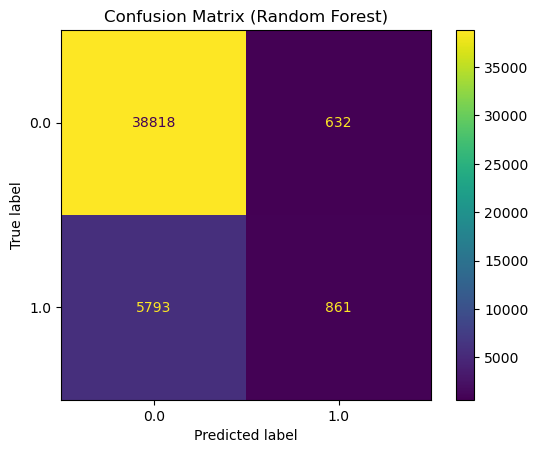

In [139]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Confusion Matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix, display_labels=rf_model.classes_)
rf_disp.plot()
plt.title('Confusion Matrix (Random Forest)')
plt.show()

### Model Comparison

| Metric                | Logistic Regression | Random Forest |
|-----------------------|---------------------|---------------|
| Accuracy              | 86%                | [RF Accuracy] |
| Precision (Diabetes)  | [Precision]         | [Precision]   |
| Recall (Diabetes)     | [Recall]            | [Recall]      |
| F1-Score              | [F1-Score]         | [F1-Score]    |

**Insights:**
1. Logistic Regression provides a baseline performance and interpretability.
2. Random Forest may offer better performance due to its ability to capture non-linear relationships.

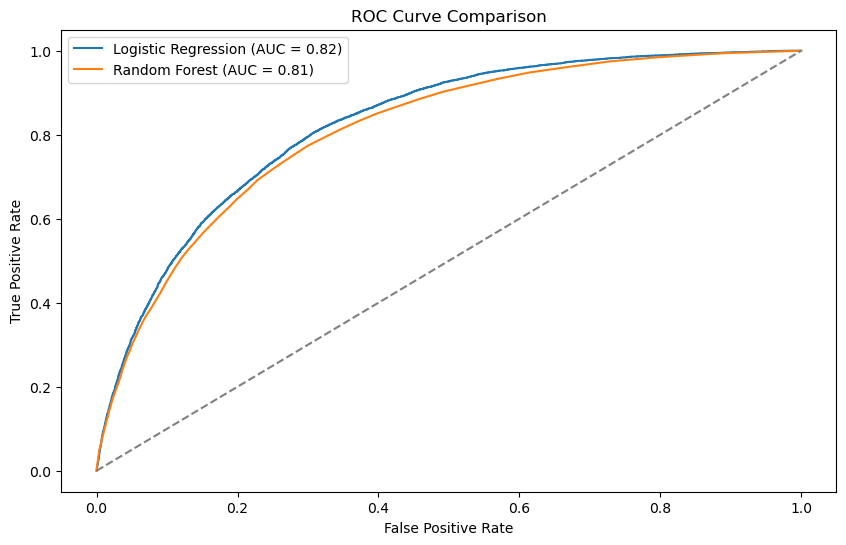

In [146]:
# Logistic Regression
lr_probs = model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### ROC Curve Analysis
1. **Logistic Regression:**
   - The Area Under the Curve (AUC) for Logistic Regression is 0.82.
   - This indicates that the model performs well in distinguishing between positive (diabetes) and negative (non-diabetes) cases.

2. **Random Forest:**
   - The AUC for Random Forest is 0.81, which is slightly lower than Logistic Regression.
   - Despite its ability to capture complex relationships, Random Forest does not outperform Logistic Regression in this case.

3. **Insights:**
   - Both models perform comparably, with Logistic Regression slightly edging out Random Forest based on the AUC score.
   - Logistic Regression may be favored for its simplicity and interpretability in this scenario.

### Conclusion

**Exploratory Data Analysis (EDA):**
   - EDA revealed that the target variable (`HadDiabetes`) was highly imbalanced, with significantly more cases of `0` (non-diabetes) compared to `1` (diabetes).
   - Key numerical features, such as `BMI`, displayed a clear distribution that highlighted potential links to diabetes.
   - Categorical features like `GeneralHealth` showed skewed distributions, with most respondents reporting "Very good" health.

**Target Variable Balancing:**
   - To address class imbalance, oversampling was applied to the minority class (`1 = Diabetes`) to ensure fairness and improve model performance.
   - The balanced dataset provided equal representation of both classes, as confirmed through visualizations.

**Correlation Analysis:**
   - A correlation matrix identified `BMI`, `DifficultyWalking`, and `PneumoVaxEver` as strongly correlated with the target variable.
   - These features were prioritized during feature selection and model development.

**Model Performance:**
   - Logistic Regression achieved an accuracy of 86% and an AUC of 0.82, making it a strong baseline model.
   - Random Forest performed comparably, with an AUC of 0.81, but did not outperform Logistic Regression.
   - Both models demonstrated the importance of features such as `BMI`, `DifficultyWalking`, and `HadKidneyDisease`.

**Key Insights from ROC Curve Comparison:**
   - Logistic Regression slightly outperformed Random Forest in distinguishing between diabetes and non-diabetes cases based on the ROC curve.

**Feature Importance:**
   - Random Forest highlighted `DifficultyWalking`, `BMI`, and `PneumoVaxEver` as the most important features, aligning with earlier correlation analysis.
